In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt
import ipy_utils
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc
import seaborn as sns
sns.set(style="white", color_codes=True)

## Plot ROC Curves for a set of GO Terms

In [7]:
def plot_roc_heat(fprs, tprs, gene_cnts, title):

    NCURVES = len(gene_cnts)
    xs = fprs

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cmap = plt.cm.YlOrRd
    min_count = int(min(gene_cnts))
    max_count = int(max(gene_cnts))
    # print min_count, max_count
    scalarMap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_count, vmax=max_count))

    for idx in range(NCURVES):
        colorVal = scalarMap.to_rgba(gene_cnts[idx])
        ax.plot(fprs[idx], tprs[idx], color=colorVal)

    ax.plot([0, 1], [0, 1], 'black')  # Plot the 50% line

    # Generate colorbar
    scalarMap.set_array([])  # You have to set a dummy-array for this to work...
    cbar = plt.colorbar(scalarMap)
    cbar.set_label('# of Genes for GO prediction')
    #cbar.set_ticks(gene_cnts)
    #cbar.set_ticklabels(['{:4.1f}'.format(yi) for yi in y]) # Make 'em nicer-looking

    ax.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.savefig(title.replace(' ','_')+'_ROC.png')
    plt.show()
    return

def make_roc_curves_lasso(GO_terms_map, GO_cnts, title='', grplasso=False):
    false_pos_rates = []
    true_pos_rates = []
    GO_terms_list = GO_terms_map.keys()
    gene_counts = [GO_cnts[term] for term in GO_terms_list]
    sorted_tuples = sorted(zip(GO_terms_list, gene_counts), key=lambda tup: tup[1], reverse=False)
    GO_terms_list = [tup[0] for tup in sorted_tuples]
    gene_counts = [tup[1] for tup in sorted_tuples]
    auc_scores = []
    for term in GO_terms_list:
        if (grplasso):
            (cur_labels, cur_probs) = GO_terms_map[term]
        else:         
            (cur_labels, cur_preds, cur_decs, cur_probs) = GO_terms_map[term]
        cur_fpr, cur_tpr, _ = roc_curve(cur_labels, cur_probs)

        #cur_fpr, cur_tpr, _ = roc_curve(cur_labels, cur_decs)
        false_pos_rates.append(cur_fpr)
        true_pos_rates.append(cur_tpr)
        auc_scores.append(roc_auc_score(cur_labels, cur_probs))
    
    plot_roc_heat(false_pos_rates, true_pos_rates, gene_counts, title)

    return auc_scores

def make_scatter_hist(GO_terms_map, GO_cnts, title='',grplasso=False):
    GO_terms_list = GO_terms_map.keys()
    gene_counts = [GO_cnts[term] for term in GO_terms_list]
    sorted_tuples = sorted(zip(GO_terms_list, gene_counts), key=lambda tup: tup[1], reverse=False)
    GO_terms_list = [tup[0] for tup in sorted_tuples]
    gene_counts = [tup[1] for tup in sorted_tuples]
    auc_scores = []
    for term in GO_terms_list:
        if (grplasso):
            (cur_labels, cur_probs) = GO_terms_map[term]
        else:         
            (cur_labels, cur_preds, cur_decs, cur_probs) = GO_terms_map[term]
        cur_fpr, cur_tpr, _ = roc_curve(cur_labels, cur_probs)

        #cur_fpr, cur_tpr, _ = roc_curve(cur_labels, cur_decs)
        auc_scores.append(roc_auc_score(cur_labels, cur_probs))
    g = sns.jointplot(np.array(gene_counts),np.array(auc_scores),xlim=(0,250),ylim=(0,1),
                      stat_func=None,ratio=4,s=40, edgecolor="w",color='m',
                      marginal_kws=dict(bins=15, rug=True),space=0)
    # g = g.set_axis_labels("# of genes for GO prediction", "AUC for GO prediction")
    lab_size = 15
    g.fig.get_axes()[0].set_ylabel('AUC score for biological function',size=lab_size)
    g.fig.get_axes()[0].set_xlabel('# of genes for biological function',size=lab_size)
    g.fig.get_axes()[0].tick_params(labelsize=14)
    g.savefig(title.replace(' ','_')+'_scatter.png')

## Get the GO terms and corresponding gene counts

In [10]:
GO_gene_counts = ipy_utils.get_GO_gene_counts('../data/GO_terms_final_gene_counts.txt')
print 'Number of GO terms: ' + str(len(GO_gene_counts))

Number of GO terms: 266


## Results Using 5-Fold CV, using Group Lasso on PCA-reduced features (all tissues)

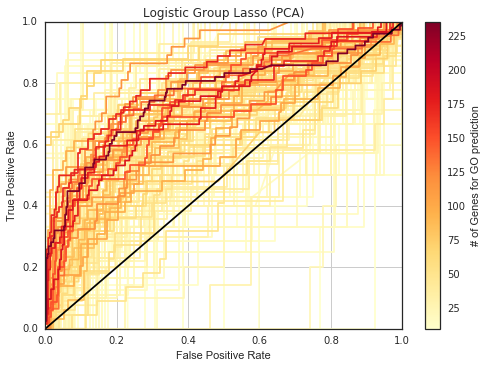

Median AUC score: 0.6810233772


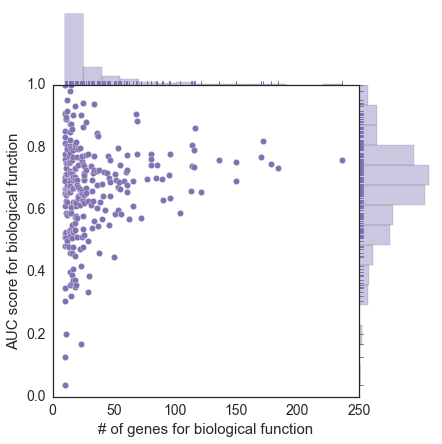

In [206]:
GO_test_map = ipy_utils.get_prediction_results_grplasso('Results/grplasso_all_results/',GO_gene_counts)
auc_scores = make_roc_curves_lasso(GO_test_map, GO_gene_counts,grplasso=True,title='Logistic Group Lasso (PCA)')
print 'Median AUC score: '+str(np.median(auc_scores))

make_scatter_hist(GO_test_map, GO_gene_counts,grplasso=True,title='ROC for Logistic Group Lasso (PCA)')

## Results Using 5-Fold CV, Logistic Regression using all 8555 Features (no feature reduction), L1 Norm

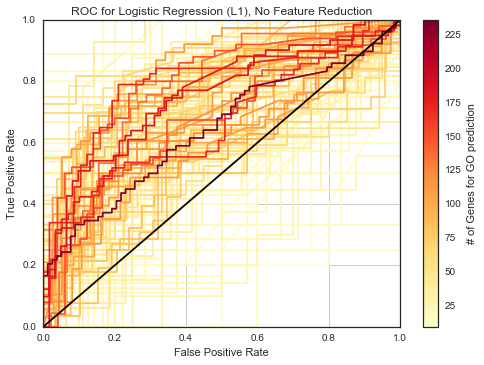

Median AUC score: 0.680753968254


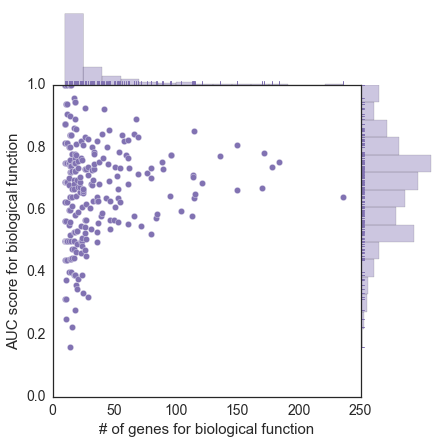

In [13]:
GO_full_results, roc_aucs_strat = ipy_utils.get_prediction_results('Results/full_results_all_tissues_loss_l1_neg_0')
title = 'ROC for Logistic Regression (L1), No Feature Reduction'
auc_scores = make_roc_curves_lasso(GO_full_results, GO_gene_counts,title=title)
make_scatter_hist(GO_full_results, GO_gene_counts,title=title)
print 'Median AUC score: '+str(np.median(auc_scores))

## Same plot as above, but using the dimension reduced features (5 features per tissue)

Observation: Using PCA, one can achieve nearly the same AUC score!

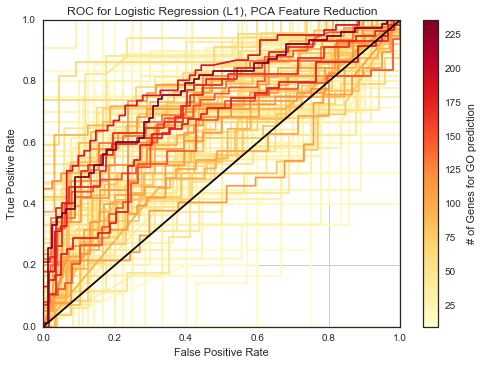

Median AUC score: 0.666666666667


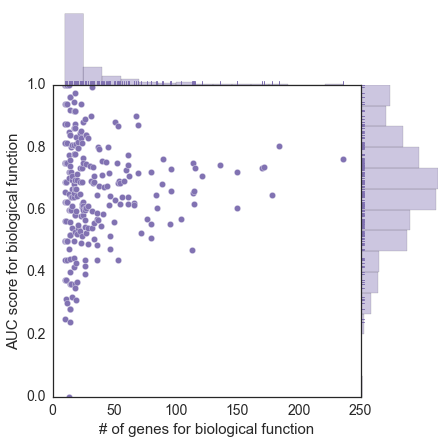

In [14]:
GO_terms, roc_aucs_strat = ipy_utils.get_prediction_results('Results/pca_results_all_tissues_loss_l1_neg_0')
title = 'ROC for Logistic Regression (L1), PCA Feature Reduction'
auc_scores = make_roc_curves_lasso(GO_terms, GO_gene_counts,title=title)
make_scatter_hist(GO_terms, GO_gene_counts,title=title)
print 'Median AUC score: '+str(np.median(auc_scores))

## Same plot as above, but only using the median sample! So each example has 53 features.

Observation: Only a slightly lower AUC!

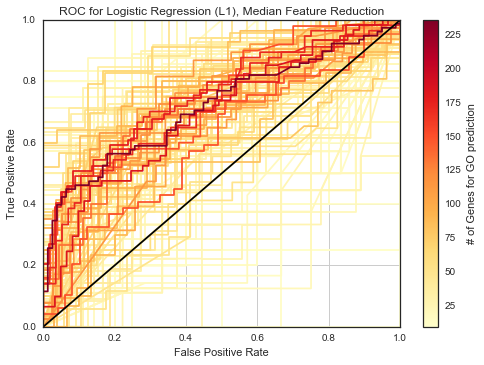

Median AUC score: 0.673098330241


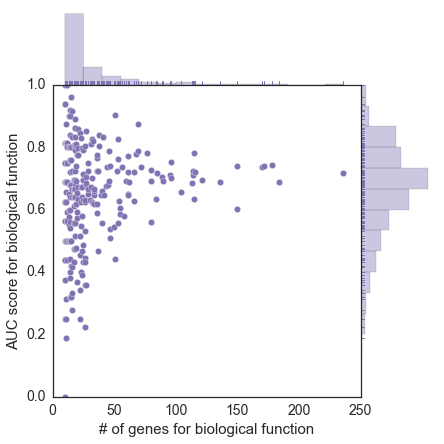

In [15]:
GO_terms, roc_aucs_strat = ipy_utils.get_prediction_results('Results/median_results_all_tissues_loss_l1_neg_0')
GO_gene_counts = ipy_utils.get_GO_gene_counts('../data/GO_terms_final_gene_counts.txt')
title = 'ROC for Logistic Regression (L1), Median Feature Reduction'
auc_scores = make_roc_curves_lasso(GO_terms, GO_gene_counts,title=title)
make_scatter_hist(GO_terms, GO_gene_counts,title=title)
print 'Median AUC score: '+str(np.median(auc_scores))